# Generating plots for Maria2019

In [7]:
from dsfunctions import forward_pass, forward_pass_nsteps, sample_windspeed, sample_winddirection, sample_geometry
from dsfunctions import plot_matrix, plot_matrix_ensemble, align_geoms, interpolate_geom, get_observation, plot_geometry
from dsfunctions import geom_to_vector, reproject_geom, validate_geom
from dsfunctions import forward_pass_farsite

import farsiteutils_v2 as futils
import datetime
import uuid

import numpy as np
from matplotlib import pyplot as plt

import contextily as ctx

import pickle
from shapely.geometry import Polygon
from tqdm import tqdm

## Load data

In [2]:
with open('./maria_results.pkl', 'rb') as f:
    adjusted_geom_lst = pickle.load(f)

description = 'Maria2019'
tfin = 10

## Load the observations

In [3]:
# MAria Fire wind values
# Windspeed and Wind direction that were used live
wslst = [11, 18, 18, 25, 17, 22, 15, 12, 14, 14, 14]
wdlst = [37, 48, 48, 44, 16, 29, 19, 24, 22, 21, 20]

# # # Bridge fire wind values
# wslst = [15]*(tfin)
# wdlst = [270]*(tfin)

# # River fire wind values
# wslst = [15]*(tfin)
# wdlst = [215]*(tfin)

observations = []
timestamps = []
sampled_wslst = []
sampled_wdlst = []

for tix in range(10):
    obs, ts = get_observation(description, tix)
    observations.append(obs)
    timestamps.append(ts)

## Generate estimated ignition

In [4]:
# Maria ignition
ignition_timepoint = timestamps[0].replace(hour=18, minute=13)
x,y = (-2084217.1484733422, 1503560.461310427)
width = 200
xshift = 2000
yshift = 1500


# # Bridge2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=12, minute=53)

# River2021 ignition
# ignition_timepoint = timestamps[0].replace(hour=14, minute=0)
# x,y = x,y = observations[0].centroid.x, observations[0].centroid.y
# width = 100
# xshift = -1200
# yshift = -2000

x += xshift
y+= yshift
ignition = Polygon([(x-width, y), (x, y), (x,y-width), (x-width, y-width)])

## Plot ignition + perimeters

0 days 00:00:00, 0 days 00:21:11
0 days 00:21:11, 0 days 00:33:11
0 days 00:54:22, 0 days 00:25:11
0 days 01:19:33, 0 days 00:26:11
0 days 01:45:44, 0 days 02:08:05
0 days 03:53:49, 0 days 00:17:00
0 days 04:10:49, 0 days 00:41:00
0 days 04:51:49, 0 days 00:25:00
0 days 05:16:49, 0 days 00:18:00
0 days 05:34:49


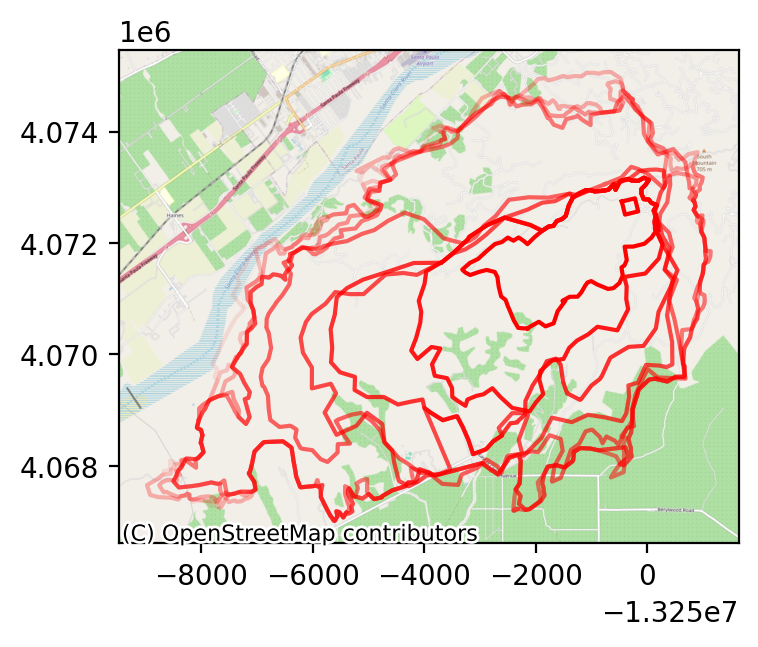

In [16]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
for i in range(tfin):
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    if i < (tfin-1):
        print(f'{timestamp - timestamps[0]}, {timestamps[i+1]-timestamps[i]}')
    else:
        print(f'{timestamp - timestamps[0]}')

# Maria boundaries
ax.set_xlim(-13259480.899793554, -13248356.055776488)
ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)

## Model output without data assimilation

### Calculate

In [9]:
no_ds_outputs = [ignition]
for tix in tqdm(range(tfin-1)):
    ws = wslst[tix]
    wd = wdlst[tix]
    dt = timestamps[tix+1]-timestamps[tix]
    model_geom = forward_pass_farsite(no_ds_outputs[-1],
                                     params = {'windspeed': ws,
                                               'winddirection': wd,
                                               'dt': dt,
                                               'description': description})
    no_ds_outputs.append(model_geom)
    

  0%|          | 0/9 [00:00<?, ?it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
 11%|█         | 1/9 [00:00<00:01,  6.29it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usr.db.dfObservation.loc[initialidx, ['filetype', 'filepath', 'datetime', 'description']] = ['Observation',
 22%|██▏       | 2/9 [00:00<00:01,  5.47it/s]/home/jovyan/farsite-devAPI/src/dsfunctions.py:391: SettingWithCopyWarning: 
A value is

## Plot model outputs

Text(0.5, 1.0, 'No data assimilation output')

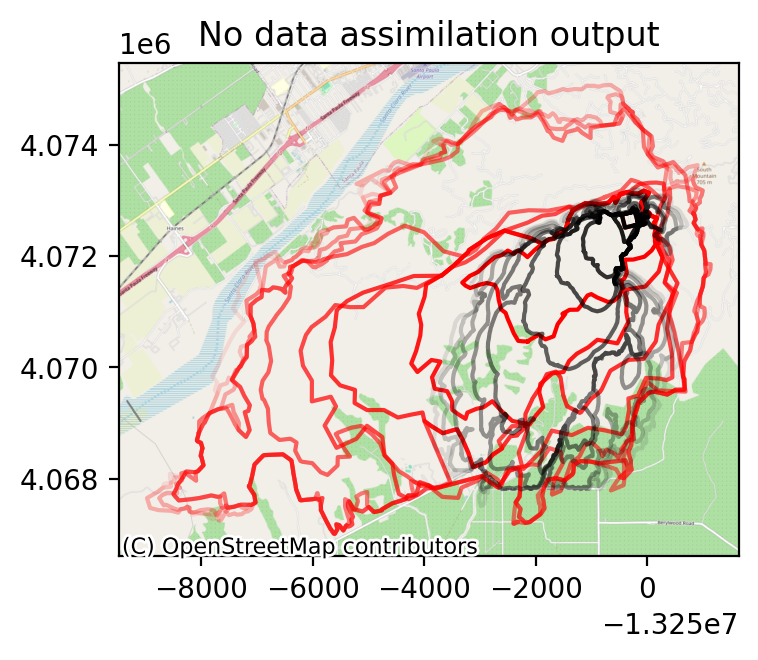

In [19]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
for i in range(tfin):
    model_geom = no_ds_outputs[i]
    plot_geometry(reproject_geom(model_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    # plot_geometry(reproject_geom(adjusted_geom), ax=ax, label=timestamp, color=(0,0,1,1-i/10), ls='--', lw=1)

# Maria boundaries
ax.set_xlim(-13259480.899793554, -13248356.055776488)
ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('No data assimilation output')

Text(0.5, 1.0, 'With data assimilation')

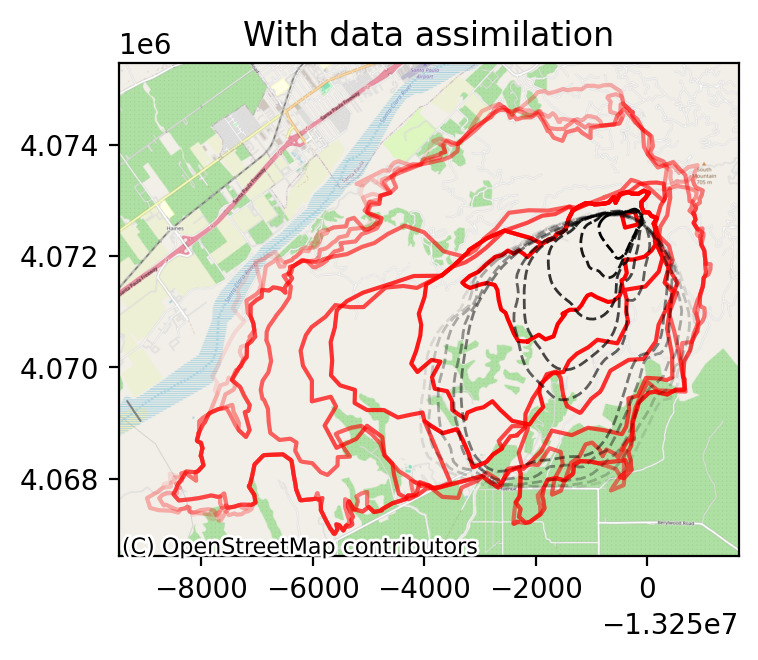

In [22]:
wdlstfig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

plot_geometry(reproject_geom(ignition), ax=ax, color='red')
for i in range(tfin):
    model_geom = no_ds_outputs[i]
    # plot_geometry(reproject_geom(model_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10))
        
    geom, timestamp = get_observation(description, i)
    plot_geometry(reproject_geom(geom), ax=ax, label=timestamp, color=(1,0,0,1-i/10))

    adjusted_geom = adjusted_geom_lst[i]
    plot_geometry(reproject_geom(adjusted_geom), ax=ax, label=timestamp, color=(0,0,0,1-i/10), ls='--', lw=1)

# Maria boundaries
ax.set_xlim(-13259480.899793554, -13248356.055776488)
ax.set_ylim(4066612.9682816155, 4075471.350794237)

# # Bridge boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

# River boundaries
# ax.set_xlim(-2.1260e6, -2.1235e6)
# ax.set_ylim(2.0470e6, 2.0485e6)

ctx.add_basemap(ax=ax, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title('With data assimilation')